<a href="https://colab.research.google.com/github/sakurasakura1996/Pytorch-start-learning/blob/master/Dive_into_DL_pytorch_5_10_5_11_5_12_%E6%89%B9%E9%87%8F%E5%BD%92%E4%B8%80%E5%8C%96_%E6%AE%8B%E5%B7%AE%E7%BD%91%E7%BB%9C_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.10批量归一化
本节我们介绍批量归一化层，他能让较深的神经网络的训练变得更加容易。在3.16房价预测kaggle，我们对输入数据做了标准化处理。处理后的任意一个特则在数据集中所有样本上的均值为0，标准差为1.标准化处理输入数据使各个特征的分布相近。这往往更容易训练出有效的模型
通常来说，数据标准化预处理对于浅层模型就足够有效了。随着模型训练的进行，当每层中参数更新时，靠近输出层的输出比较难出现剧烈变化。但对深层神经网络来说，即使输入数据已做了标准化，训练中模型参数的更新依然很容易造成靠近输出层输出的剧烈变化，这种计算数值的不稳定性通常令我们难以训练出有效的模型

批量归一化的提出正是为了应对深度模型训练的挑战，在模型训练时批量归一化利用小批量上的均值和标准差，不断调整神经网络中间输出，从而使整个神经网络在各层的中间输出的数值更稳定。

批量归一化和下节介绍的残差网络为训练和设计深度模型提供了两类重要思路


对全连接层和卷积层做批量归一化的方法稍有不同。下面我们将分别介绍这两种情况下的批量归一化
### 对全连接层做批量归一化
我们通常将批量归一化置于全连接层中的仿射变换和激活函数之间。设全连接层的输入为u，权重参数和偏差参数分别为W，b，激活函数为f，设批量归一化的运算符为BN，那么，使用批量归一化的全连接层的输出为 f(BN(x)). 其中批量归一化输入x由仿射变换 x = Wu+b得到。考虑一个小批量的输入，首先对小批量求均值和方差，然后 做标准化，最后在做一个线性变换。

### 对卷积层做批量归一化
对卷积层，批量归一化发生在卷积计算之后。应用激活函数之前。如果卷积运算输出多个通道，我们需要对这些通道的输出分别做批量归一化，且每个通道都拥有独立的拉伸和偏移参数，并均为标量。设小批量中有m个样本。在单个通道上，假设卷积运算输出的高和宽分别为p和q。我们需要对该通道中mxpxq 各元素同时做批量归一化。对这些元素做标准化计算时，我们使用相同的均值和方差，即该通道中mxpxq个元素的均值和方差。批量归一化训练时，我们可以将批量大小设的大一点，从而使得批量样本内的均值和方差更准确些



In [0]:
import torch
from torch import nn, optim
import time
import torch.nn.functional as F
import torchvision

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batch_norm(is_training, X, gamma, beta, moving_mean, moving_var, eps, momentum):
  # 判断当前是训练模式还是预测模式
  if not is_training:
    # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
  else:
    assert len(X.shape) in (2, 4)   # assert用于判断表达式，如果为false，则直接返回结果，而不用等待后面崩溃不得不停止
    if len(X.shape) == 2:
      # 使用全连接层的情况，计算特征维上的均值和方差
      mean = X.mean(dim=0)
      var = ((X-mean) ** 2).mean(dim=0)
    else:
      # 使用二维卷积的情况，计算通道维上axis=1的均值和方差。这里我们需要保持X的形状方便后面做广播运算
      mean = X.mean(dim=0, keepdim=True).mean(dim=2,keepdim=True).mean(dim=3,keepdim=True)
      var = ((X-mean) ** 2).mean(dim=0,keepdim=True).mean(dim=2,keepdim=True).mean(dim=3,keepdim=True)
    # 训练模式下用当前的均值和方差做标准化
    X_hat = (X - mean) / torch.sqrt(var+eps)
    # 更新移动平均的均值和方差
    moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
    moving_var = momentum * moving_mean + (1.0 - momentum) * var
  Y = gamma * X_hat + beta # 拉伸和偏移
  return Y, moving_mean, moving_var


In [0]:
# 接下来自定义一个 BatchNorm层。他保存参与求梯度和迭代的拉伸参数gamma和 偏移参数 beta，同时也维护移动平均得到的均值和方差，以便能够在模型预测时被使用。BatchNorm实例所需指定的
# num_features参数对于全连接层来说应为输出个数，对于卷积层来说则为输出通道数。该实例所需指定的num_dims参数对于全连接层和卷积层来说分别为2和4
class BatchNorm(nn.Module):
  def __init__(self, num_features, num_dims):
    super(BatchNorm, self).__init__()
    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)
    # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成0和1
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))
    # 不参与求梯度和迭代的变量，全在内存上初始化为0
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.zeros(shape)
  
  def forward(self, X):
    # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)
    # 保存更新过的moving_mean和moving_var,Module实例的training属性默认为true，调用.eval()后设成false
    Y, self.moving_mean, self.moving_var = batch_norm(self.training, X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9)
    return Y

In [0]:
class FlattenLayer(nn.Module):
  def __init__(self):
    super(FlattenLayer, self).__init__()
  def forward(self, x): # x shape: (batch, *, *, ...)
    return x.view(x.shape[0], -1)

In [0]:
# 使用批量归一化层的LeNet
net = nn.Sequential(
    nn.Conv2d(1, 6, 5),  # in_channels, out_channels, kernel_size
    BatchNorm(6, num_dims=4),
    nn.Sigmoid(),
    nn.MaxPool2d(2,2),   # kernel_size, stride
    nn.Conv2d(6, 16, 5),
    BatchNorm(16, num_dims=4),
    nn.Sigmoid(),
    nn.MaxPool2d(2, 2),
    FlattenLayer(),
    nn.Linear(16*4*4, 120),
    BatchNorm(120, num_dims=2),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    BatchNorm(84, num_dims=2),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [0]:
def load_data_fashion_mnist(batch_size,resize=None):
  trans = []
  if resize:
    trans.append(torchvision.transforms.Resize(size=resize))
  trans.append(torchvision.transforms.ToTensor())

  transform = torchvision.transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(root='~/root/Datasets/FashionMNIST',train=True,download=True,transform=transform)
  mnist_test = torchvision.datasets.FashionMNIST(root='~/root/Datasets/FashionMNIST',train=False,download=True,transform=transform)

  train_iter = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size,shuffle=True,num_workers=4)
  test_iter = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size,shuffle=False,num_workers=4)
  return train_iter, test_iter
    


In [0]:
def evaluate_accuracy(data_iter, net, device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
  acc_sum, n =0.0, 0
  with torch.no_grad():
    for X,y in data_iter:
      if isinstance(net, torch.nn.Module):
        net.eval()   # 评估模式，这回关闭dropout
        acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
        net.train()  # 改回训练模式
      else:
        if('is_training' in net.__code__.co_varnames):
          acc_sum += (net(X,is_training=False).argmax(dim=1) == y).float().sum().item()
        else:
          acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
      n += y.shape[0]
  return acc_sum / n

In [0]:
def train_ch5(net, train_iter, test_iter, batch_size, optimizer, device, num_epochs):
  net = net.to(device)
  print("training on ",device)
  loss = torch.nn.CrossEntropyLoss()
  batch_count = 0
  for epoch in range(num_epochs):
    train_acc_sum, train_l_sum, n, start = 0.0, 0.0, 0, time.time()
    for X, y in train_iter:
      X = X.to(device)
      y = y.to(device)
      y_hat = net(X)
      l = loss(y_hat,y)
      optimizer.zero_grad()
      l.backward()
      optimizer.step()
      train_l_sum += l.cpu().item()   # 这里应该是可以节省gpu空间吧
      train_acc_sum += (y_hat.argmax(dim=1)==y).sum().cpu().item()
      n += y.shape[0]
      batch_count += 1
    test_acc = evaluate_accuracy(test_iter, net)
    print("epoch: %d, loss: %.4f, train_acc: %.4f, test_acc: %.4f, time: %.1f"%(epoch+1,train_l_sum/batch_count, train_acc_sum/n, test_acc, time.time()-start))


In [0]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
train_ch5(net, train_iter, test_iter, batch_size, optimizer,device, num_epochs)

training on  cuda
epoch: 1, loss: 0.9842, train_acc: 0.7901, test_acc: 0.1000, time: 6.9
epoch: 2, loss: 0.2235, train_acc: 0.8660, test_acc: 0.1000, time: 6.7
epoch: 3, loss: 0.1205, train_acc: 0.8809, test_acc: 0.1000, time: 6.8
epoch: 4, loss: 0.0813, train_acc: 0.8885, test_acc: 0.1000, time: 6.7
epoch: 5, loss: 0.0607, train_acc: 0.8938, test_acc: 0.1000, time: 6.7


In [0]:
net[1].gamma.view((-1,)), net[1].beta.view((-1,))

(tensor([0.9610, 1.1611, 1.1993, 1.1794, 1.0033, 1.0540], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([-0.6658,  0.5085,  0.2152, -0.0855, -0.0253, -0.6202], device='cuda:0',
        grad_fn=<ViewBackward>))

In [0]:
# 简洁实现
net = nn.Sequential(    
    nn.Conv2d(1, 6, 5), # in_channels, out_channels, kernel_size
    nn.BatchNorm2d(6),
    nn.Sigmoid(),
    nn.MaxPool2d(2, 2), # kernel_size, stride
    nn.Conv2d(6, 16, 5),
    nn.BatchNorm2d(16),
    nn.Sigmoid(),
    nn.MaxPool2d(2, 2),
    FlattenLayer(),
    nn.Linear(16*4*4, 120),
    nn.BatchNorm1d(120),
    nn.Sigmoid(),
    nn.Linear(120, 84),
    nn.BatchNorm1d(84),
    nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [0]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
train_ch5(net, train_iter, test_iter, batch_size, optimizer,device, num_epochs)

training on  cuda
epoch: 1, loss: 1.0109, train_acc: 0.7735, test_acc: 0.8099, time: 6.5
epoch: 2, loss: 0.2376, train_acc: 0.8558, test_acc: 0.8493, time: 6.5
epoch: 3, loss: 0.1262, train_acc: 0.8737, test_acc: 0.8510, time: 6.5
epoch: 4, loss: 0.0851, train_acc: 0.8821, test_acc: 0.8538, time: 6.5
epoch: 5, loss: 0.0634, train_acc: 0.8887, test_acc: 0.8766, time: 6.4


# 5.11 残差网络（ResNet）
神经网络添加过多的层后，训练误差往往不降反升。针对该问题，何凯明等人提出了残差网络ResNet。
## 5.11.2 残差块
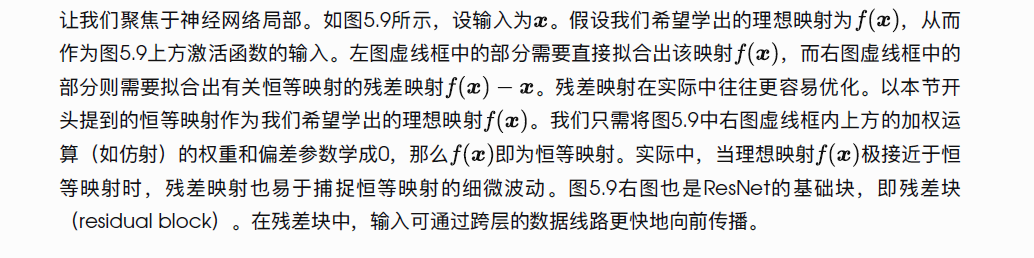
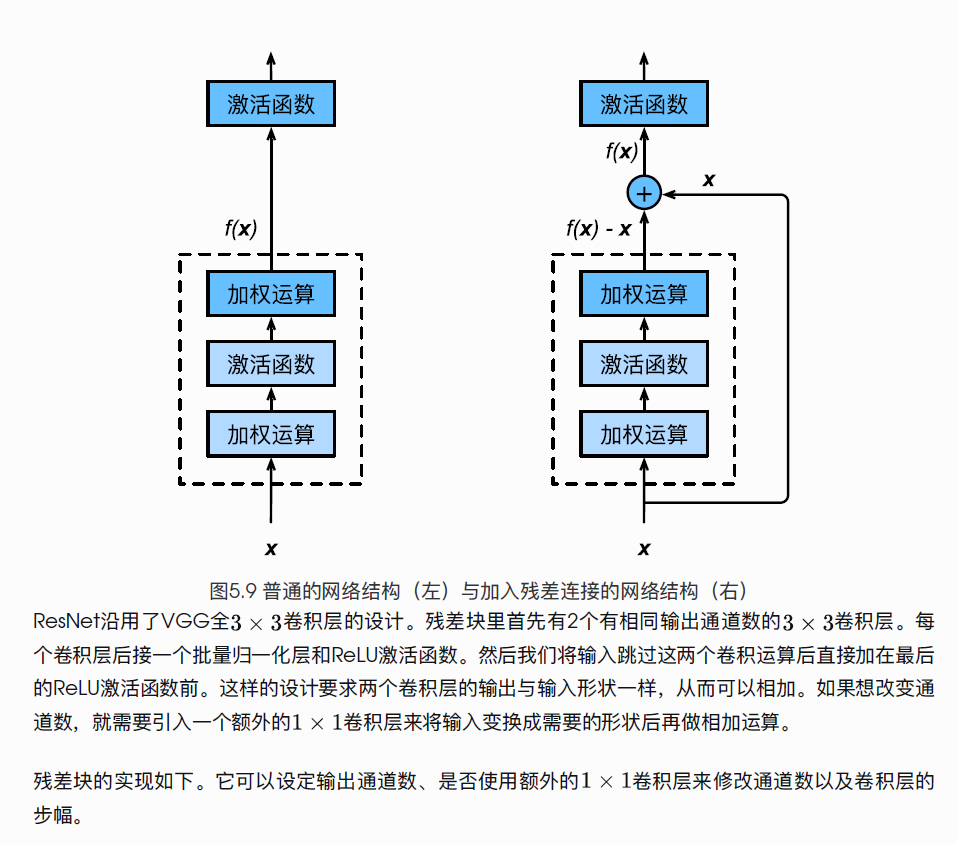

In [0]:
class Residual(nn.Module):
  def __init__(self, in_channels, out_channels,use_1x1conv=False, stride=1):
    super(Residual, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1, stride=stride)
    self.conv2 = nn.Conv2d(out_channels, out_channels,kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv2d(in_channels, out_channels,kernel_size=1, stride=stride)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.bn2 = nn.BatchNorm2d(out_channels)

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    return F.relu(Y + X)


In [0]:
# 下面看看输入 和 输出形状一致的情况
blk = Residual(3, 3)
X = torch.rand((4, 3, 6, 6))
blk(X).shape

torch.Size([4, 3, 6, 6])

In [0]:
# 我们也可以在增加输出通道数的同时减半输出的高和宽
blk = Residual(3, 6, use_1x1conv=True, stride=2)
blk(X).shape # torch.Size([4, 6, 3, 3])

torch.Size([4, 6, 3, 3])